## Overview
Tasks: There are two parts/tasks in this tutorial: 
1. Developing a deep learning system for perception of signboards in PyTorch 
2. Rewriting our code using PyTorch Lightning

- Time: If you are comfortable with PyTorch, this tutorial should take around 1-2 hours max.


### Import required libraries and packages

In [123]:
# If you run on Jupyter Lab uncomment bellow comment
#! pip install --quiet "matplotlib" "pytorch-lightning" "pandas" "torchmetrics"

# If you run on google colab uncomment bellow comment
# !pip install "pytorch-lightning" "torchmetrics"  -qq

# If you are running on your IDE (e.g VSCode) select the virtual environment that you have created as your python kernel
import os

import random

import matplotlib.colors as mpcol

import numpy as np # it's numpy, of course we need it!

import pandas as pd # for handling data

import matplotlib.pyplot as plt # for plotting

import math

from PIL import Image

import torch # this is PyTorch
import torch.nn as nn # The torch.nn module contains the building blocks for our neural networks
from torch.nn import functional as F # functional is a subpackage that contains various different deep learning functions (e.g activation functions)
from torch import optim # is a package that implements various optimization algorithms used for training
from torch.utils.data.dataset import Dataset # We require the Dataset and DataLoader classes if we are handling custom data
from torch.utils.data import DataLoader, random_split

import torchmetrics # will need to install this separately, contains implementations for various metrics (e.g Accuracy)
import torchvision # will need to install this separately, consists popular datasets, model architectures, and common image transformations for computer vision.

from torchmetrics import Accuracy
from torchvision import transforms
import torchvision.transforms.functional as fn

from pytorch_lightning import LightningModule, Trainer, seed_everything # PyTorch lightning is essentially an abstraction of vanilla PyTorch
                                                                        # This is an optional install/import, but from personal experience I find
                                                                        # coding neural networks with lightning much easier (we'll look at the details in the slides)

from pytorch_lightning.callbacks.progress import TQDMProgressBar # Progress bar that lets you know that something is actually happening
from pytorch_lightning.loggers import CSVLogger # Logging function to log information after every training epoch (e.g train accuracy)
from pytorch_lightning.callbacks import Callback, ModelCheckpoint # For saving and loading checkpoints. Callbacks allow you to call functions after every training epoch

from tqdm import tqdm

# For reproducability
seed_everything(1234, workers=True)

# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu') 

Global seed set to 1234


In [124]:
print(device)
print(torch.cuda.is_available())

cuda:0
True


### Dataset Preparation

Before we begin, we need to prepare our dataset. We will be using the German Traffic Sign Recognition Benchmark (GTSRB) dataset, which can be found at this link: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign (642 MB)

The data will be downloaded as a zip file, which you can then extract. Make sure to place all folders/files into this directory (Tutorial_2).

This whole process could take a while, especially extracting and copying over the files, so give yourself some time before coding to get this data ready (it took me 30min!).

In [125]:
DATA_DIR = '../Tutorial_2/data'
# TEST_DIR = '../Tutorial_2/data/Test'
# TRAIN_DIR = '../Tutorial_2/data/Train'
NUM_CATEGORIES = 43

In [126]:
class_labels = ['20 km/h', '30 km/h', '50 km/h', '60 km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking',
               'No overtaking for trucks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for truck', 'Block',
               'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light',
               'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right', 
               'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for truck']

In [127]:
# This function just visualises some of the images
def visualise_data(images, categories=None, 
                   test_categories=None,
                   class_names = labels, 
                   images_per_row = 5):
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(3*images_per_row, 3*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        ax = plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        # ----
        try:
          ax.imshow(np.array(images[i]).astype('uint8'))
        except:
           image = images[i].permute(1,2,0)
           ax.imshow(np.array(image).astype('uint8'))
          
        if test_categories is not None:
          if int(test_categories[i]) == int(categories[i]):
            ax.set_title("Source: " + class_names[int(categories[i])] + "\nPredicted: " + class_names[int(test_categories[i])], fontsize=10, color='green')
          else:
            ax.set_title("Source: " + class_names[int(categories[i])] + "\nPredicted: " + class_names[int(test_categories[i])], fontsize=10, color='red')
        else:
          ax.set_title(class_names[int(categories[i])])
        # ----
    plt.show()

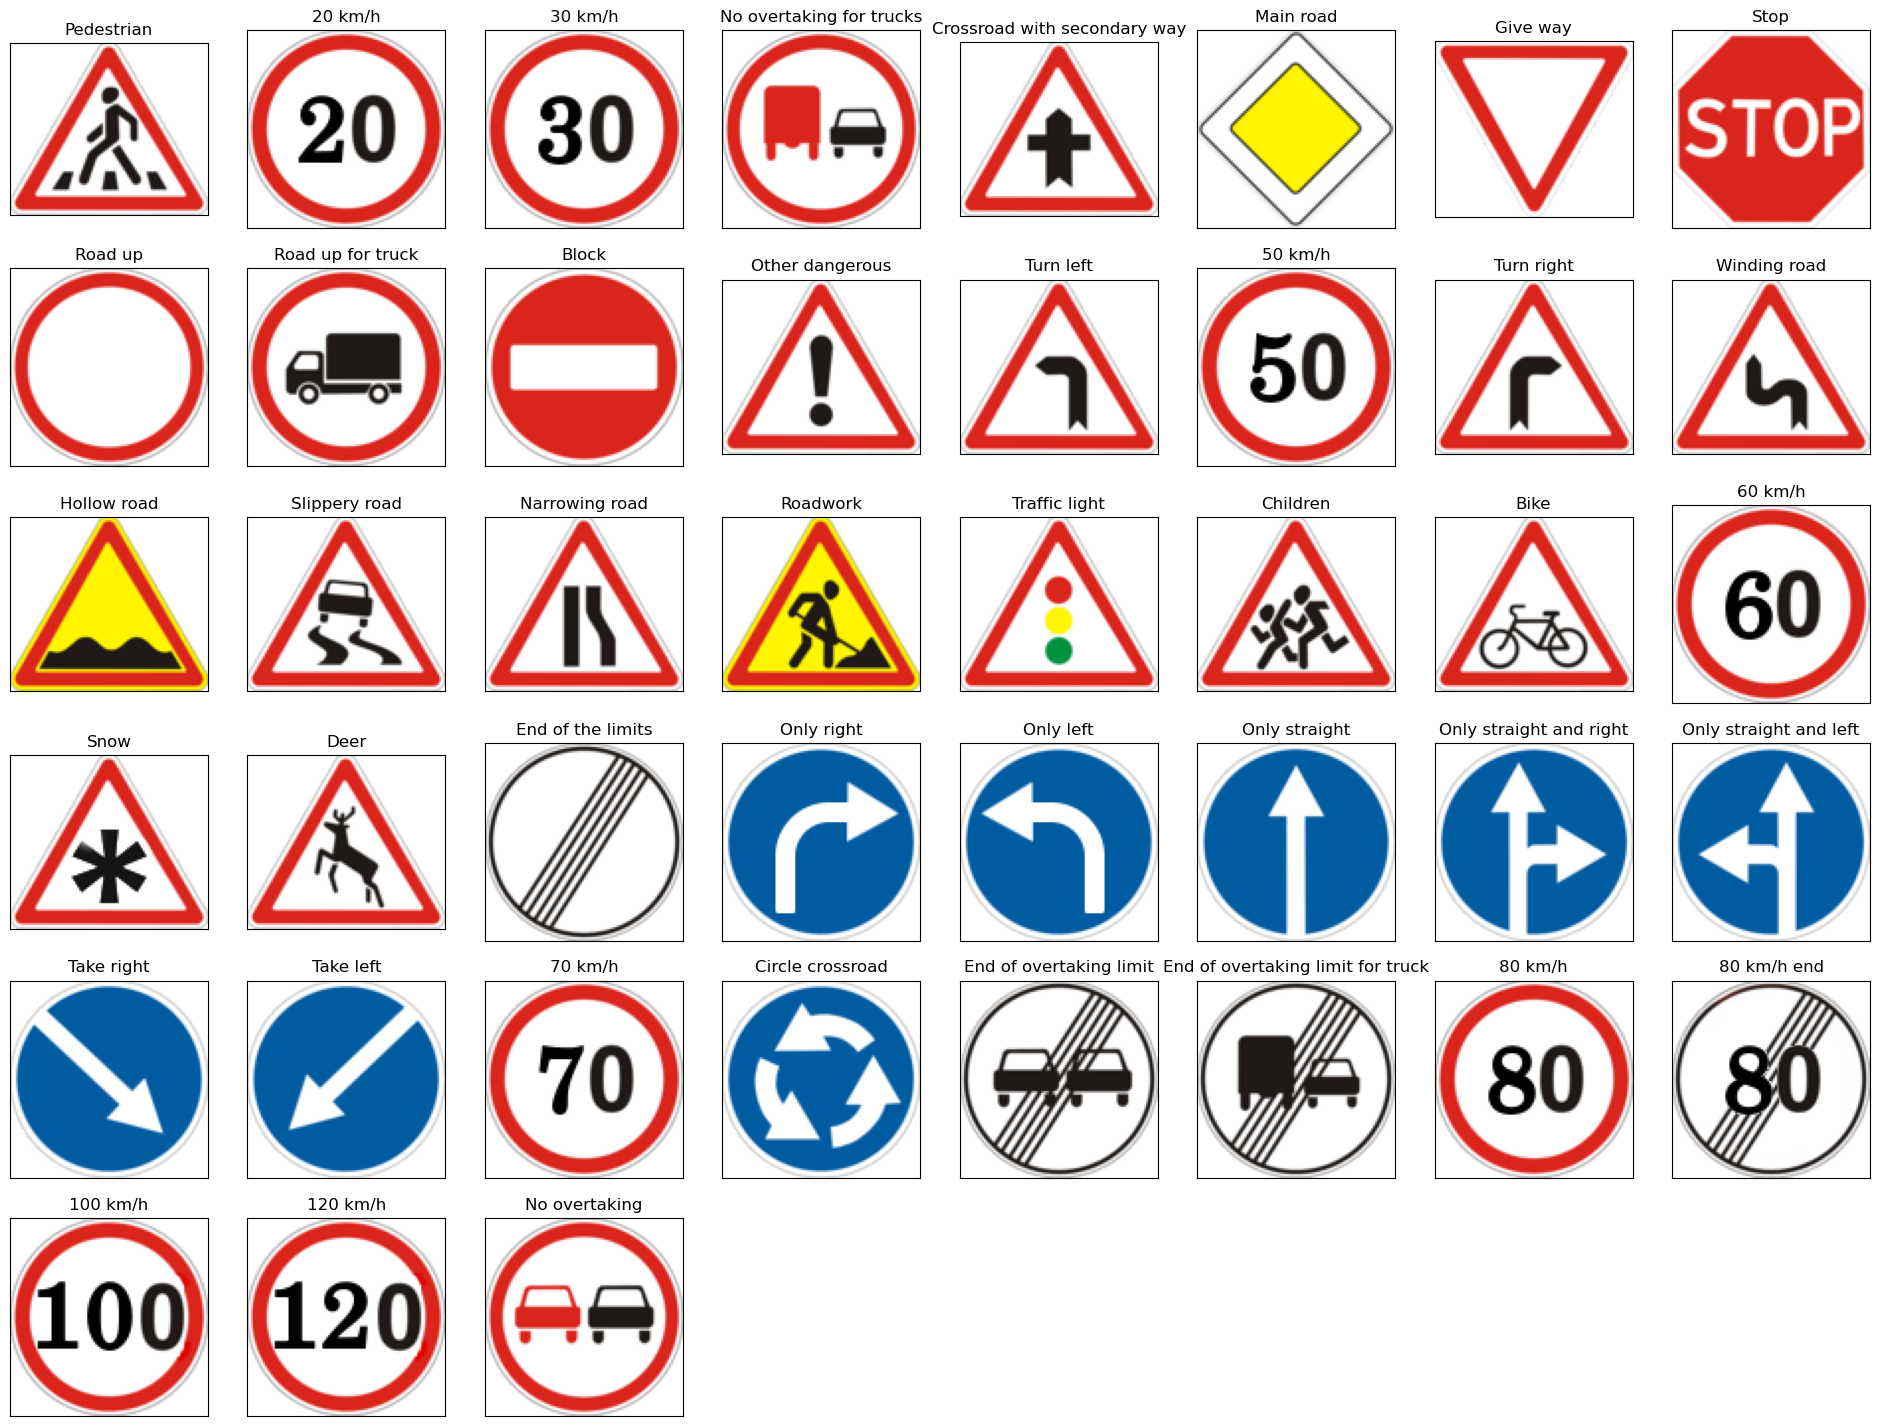

In [128]:
# Printing out the labels for all 43 classes
meta_csv = pd.read_csv(DATA_DIR + '/Meta.csv')
class_im_paths = meta_csv.loc[:,"Path"]
class_images = []
for image in class_im_paths:
  class_images.append(Image.open(DATA_DIR + "/" + image))

class_Id = meta_csv.loc[:,"ClassId"]

visualise_data(class_images, categories = class_Id, class_names=class_labels, images_per_row=8)

In [129]:
# To keep our model compact, we will utilise a 32x32x3 input by resizing our images to this size
# Don't worry, CNNs are pretty powerful and we should still be able to get a good result!
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CHANNELS = 3

In [130]:
class TrafficSignData(Dataset):
    def __init__(self, train=True, transform=None):
        self.images = []
        self.labels = []

        if train:
            self.path = DATA_DIR + '/Train'
            self.directory = os.listdir(self.path) # list all subfolders

            for folder in self.directory:
                sub_path = self.path + "/" + str(folder)
                image_path = os.listdir(sub_path) # list images in each subfolder (each subfolder represents one of the 43 classes)
                for file in image_path:
                    if file[-1] == 'r': # NOTE THIS JANKY AS SOLUTION IS ONLY BECAUSE I HAVE "ZoneIdentifier" files for some reason when i copy over to WSL
                        continue
                    image = np.asarray(fn.resize((Image.open(sub_path + '/' + str(file))), (IMG_HEIGHT, IMG_WIDTH))).astype('float32')
                    self.images.append(image) # add image to our data array
                    self.labels.append(int(folder)) # add corresponding label to our label array
        else:
            test_csv = pd.read_csv(DATA_DIR + '/Test.csv')
            test_im_paths = test_csv.loc[:,"Path"]

            for image in test_im_paths:
                # self.images.append(np.asarray(Image.open(DATA_DIR + "/" + image)).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3).astype('float32'))
                self.images.append(np.asarray(fn.resize((Image.open(DATA_DIR + '/' + image)), (IMG_HEIGHT, IMG_WIDTH))).astype('float32'))

            self.labels = test_csv.loc[:, "ClassId"]
        self.images = np.asarray(self.images)
        self.labels = np.asarray(self.labels)
        self.transform = transform

    def __getitem__(self, idx):
        if torch.is_tensor(idx): # idx will be a list of indexes as we will  be BATCHING
            idx = idx.tolist()
            
        sample = self.images[idx,:] # self.images is a two-dimensional array, the first dimension stores the image index and the second stores the image pixel values
        labels = self.labels[idx]
        if self.transform:  ## If there is a transform, apply it here to your sample
            sample = self.transform(sample)
        return sample, labels
    
    def __len__(self):
        return len(self.labels) # length of labels = length of images


In [131]:
BATCH_SIZE = 128     # the batch size for training task 1
N_WORKERS = 0        # don't worry too much about this

# Data augmentations - make sure to transform to tensor!
transform = transforms.Compose([transforms.ToTensor()])

# Create an instance of the German Roadsign dataset for the training and test set (no validation set provided, however we could partition one)
# Remember we defined TrafficSignData(train=True, transform=None)
train_set = TrafficSignData(train=True, transform=transform)
test_set = TrafficSignData(train=False, transform=transform)

# Now we need to pass the dataset to the Pytorch dataloader class along with some other arguments
# DataLoader(dataset = dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=N_WORKERS), make sure to shuffle the train dataset!
trainloader = DataLoader(dataset = train_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=N_WORKERS)
testloader = DataLoader(dataset = test_set, shuffle=False, batch_size=BATCH_SIZE, num_workers=N_WORKERS)

## Part 1: Creating our Deep CNN Classifier in PyTorch

There's no defined architecture that you need to use, but a possible example could be:

conv1 -> relu -> maxpool -> dropout -> conv2 -> relu -> maxpool -> dropout -> conv3 -> relu -> maxpool -> drouput -> FC1 -> relu -> drouput -> FC2 -> out

The point I want to make here is play around with the depth and layers you use in this CNN classifier (deeper isn't always better!). See which combinations work better than others, not just in terms of accuracy but also in terms of speed of training and overall memory usage. Be curious!

If you have any questions are certain things aren't working, shoot me a question.

Here are some notes:
- Make sure that the input number of channels to the first conv layer is 3
- Make sure that the output number of channels (i.e kernels) from one conv layer is equal to the input number of channels to the following conv layer
- Play around with kernel size, padding and stride to see how the dimensionality of your intermediate inputs change. Use the attached formula for help.
- If you apply maxpooling, make sure to account for this when calculating the output dimensions per layer!
- Make sure to apply activation functions to your intermediate layers (NOT OUTPUT LAYER!)
- Make sure to flatten the output of your final conv layer into a 1D vector before feeding it into your fully connected network
- You can apply dropout layers within your model to force parameters to learn useful information (again don't apply it to output layer)

CNN Dimensionality formula:

![image](CNNformula.png)
- W_i is input width/height
- k_w is kernel size
- p_w is padding size
- s_w is stride length
- Take the floor

In [132]:
class CNNClassifier(nn.Module): # This is our main model
    def __init__(self):
        super().__init__()

        # BSxWxHxC: Input is BSx32x32x3, output is BSx32x32x16
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2, stride=1)

        # Input is BSx16x16x16, output is BSx16x16x32
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2, stride=1)

        # Input is BSx8x8x32, output is BSx8x8x64
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2, stride=1)

        # Input is BSx4x4x64
        self.fc1 = nn.Linear(4*4*64, 128)

        self.out = nn.Linear(128,43)

        # Define Max Pooling (Default stride = kernel size)
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        # conv 1
        x = F.dropout(self.maxpool(F.relu(self.conv1(x))), p=0.2)

        # conv 2
        x = F.dropout(self.maxpool(F.relu(self.conv2(x))), p=0.2)

        # conv 3
        x = F.dropout(self.maxpool(F.relu(self.conv3(x))), p=0.2)

        # flatten for linear layers
        x = x.view(x.shape[0],-1)

        # fc1
        x = F.dropout((F.relu(self.fc1(x))), p=0.5)

        # output
        out = self.out(x)
        # don't need softmax here since we'll use cross-entropy as our loss function
        return out

### Training our CNN Model

In [133]:
LEARNING_RATE = 1e-3

loss_function = nn.CrossEntropyLoss()

model = CNNClassifier()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [136]:
# simple empty array to log the loss
loss_log = []
accuracy_log = []

# Perform 5 epochs
for epoch in range(5):
    correct = 0
    loop = tqdm(trainloader)
    for idx, (x_batch, y_batch) in enumerate(loop):
        # perform forward pass
        target_pred = model(x_batch)

        # calc loss
        loss = loss_function(target_pred, y_batch)

        # calc accuracy
        correct += torch.sum(target_pred.argmax(1) == y_batch)

        # zero gradients from previous step to avoid adding gradients
        optimizer.zero_grad()

        # calculate new gradients
        loss.backward()

        # perform gradient descent
        optimizer.step()

    # Store loss at end of epoch
    loss_log.append(loss.item())

    # Store accuracy at end of epoch
    train_acc = correct/len(train_set)
    accuracy_log.append(train_acc)

    # Print out results
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}, Train Accuracy: {train_acc}")

    

100%|██████████| 307/307 [00:25<00:00, 11.88it/s]


Epoch: 1, Loss: 1.4313578605651855
Epoch: 1, Train Accuracy: 0.2796296775341034


100%|██████████| 307/307 [00:17<00:00, 17.64it/s]


Epoch: 2, Loss: 1.254249095916748
Epoch: 2, Train Accuracy: 0.5474763512611389


100%|██████████| 307/307 [00:15<00:00, 19.81it/s]


Epoch: 3, Loss: 0.5141903758049011
Epoch: 3, Train Accuracy: 0.7034609317779541


100%|██████████| 307/307 [00:14<00:00, 20.89it/s]


Epoch: 4, Loss: 0.4560457170009613
Epoch: 4, Train Accuracy: 0.7930067181587219


100%|██████████| 307/307 [00:13<00:00, 23.31it/s]

Epoch: 5, Loss: 0.3396901488304138
Epoch: 5, Train Accuracy: 0.8418475389480591


### Visualise Results

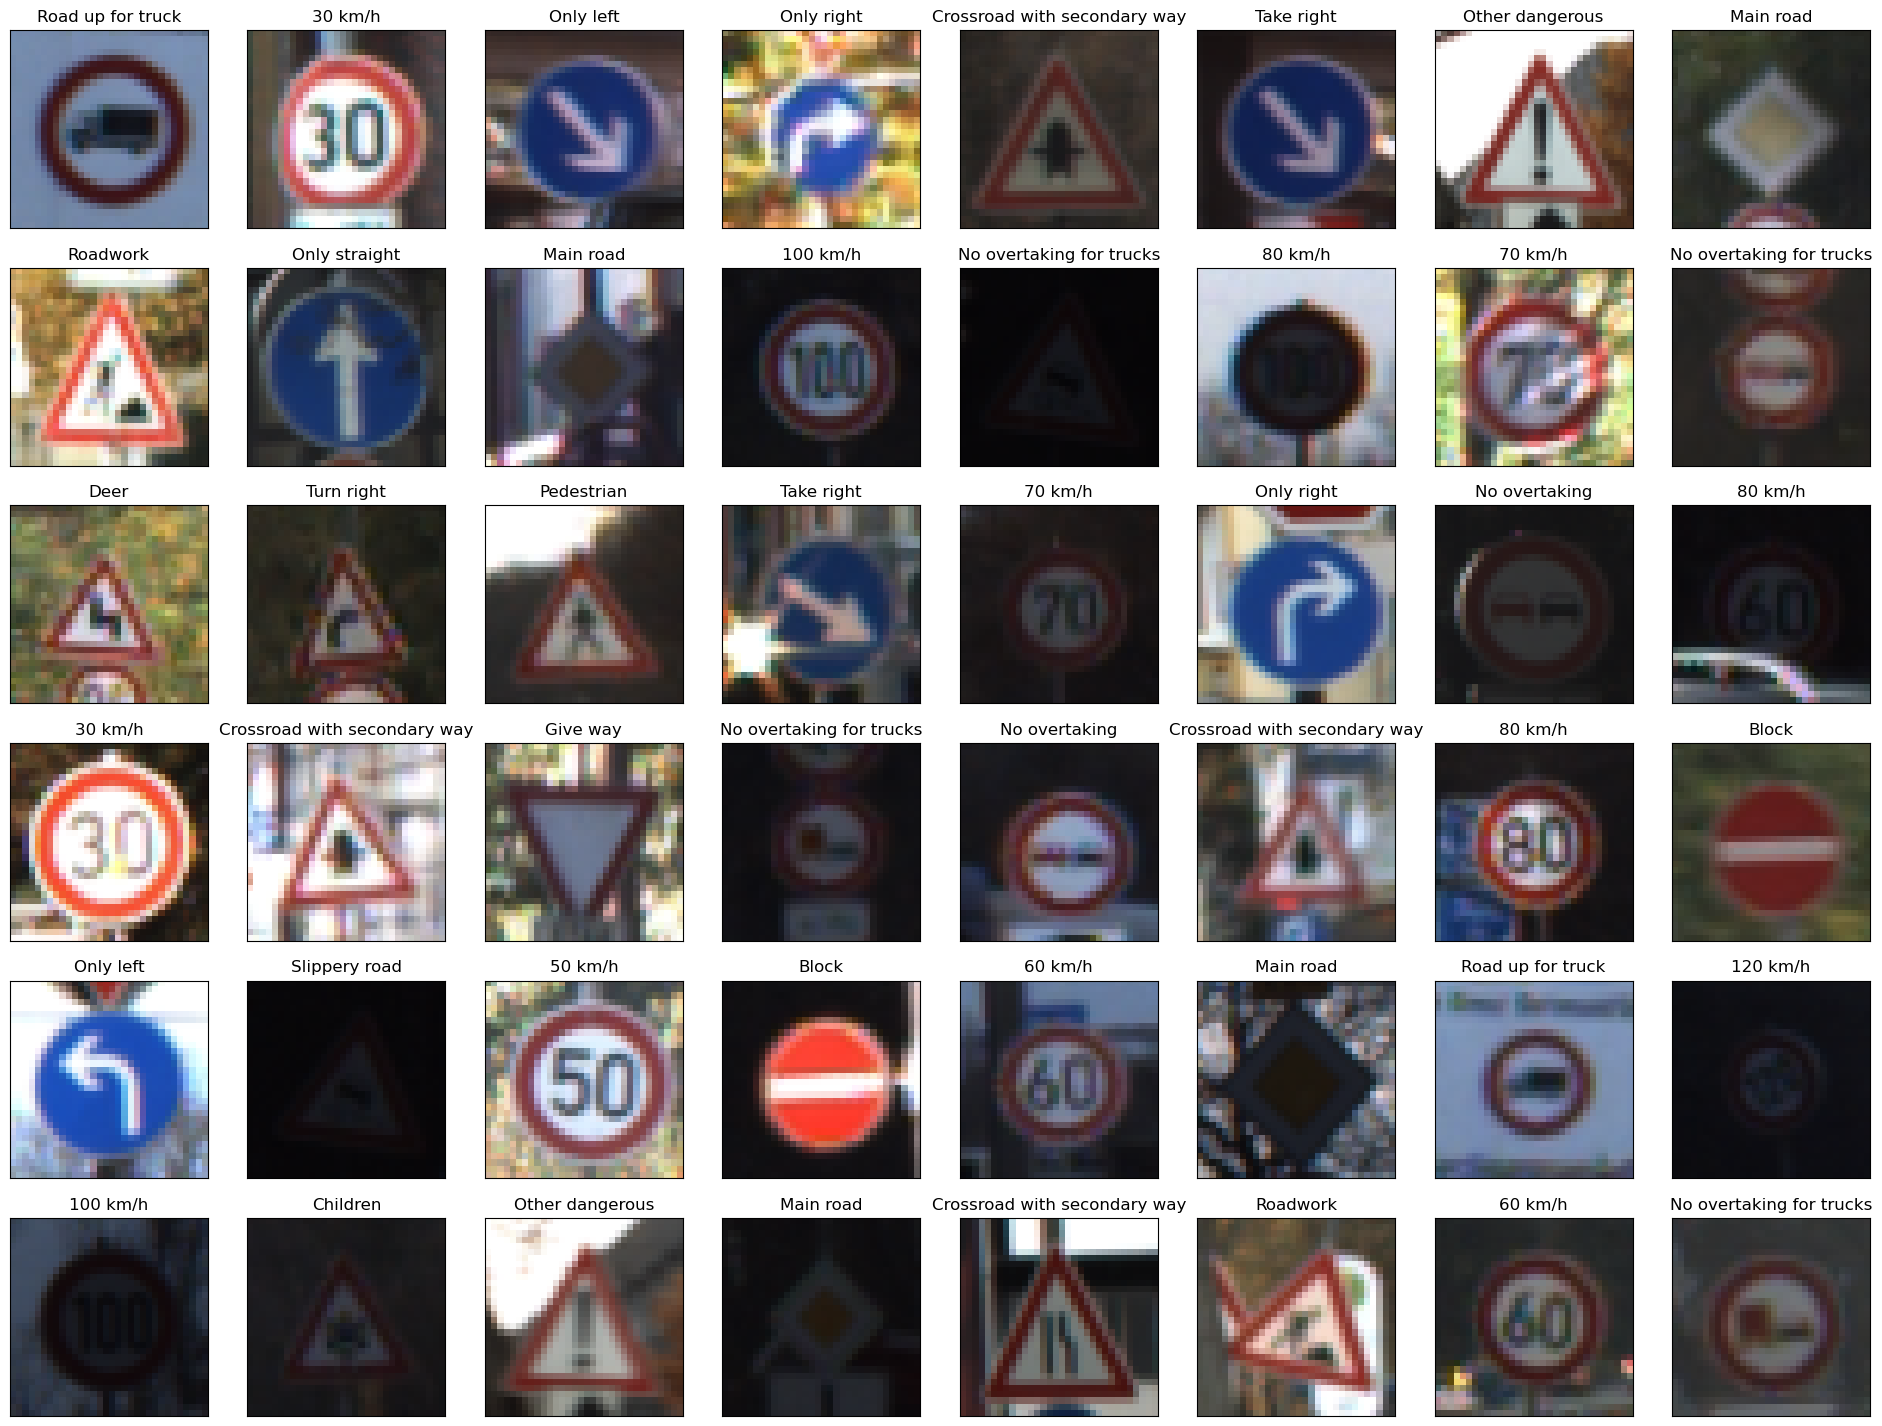

In [137]:
# Generate predictions using predict function
# Take a random test sample
test_data_iterator = iter(testloader)
data, labels = next(test_data_iterator)

predicted_labels = model(data).argmax(1) # might need to set to model.eval()!!!

input_im = data[0:48] # 6 rows
ground_truth = labels[0:48]
predicted = predicted_labels[0:48].numpy()

visualise_data(input_im, categories = predicted, class_names=class_labels, images_per_row=8)


### Saving Model Weights and Reloading from Checkpoint

To save our model weights, we simply save the state of our model. We can also include more information to generate a general checkpoint, including things such as the state of the optimizer, the epoch we left off from and the last recorded loss.

In [140]:
PATH = "../Tutorial_2/checkpoints/checkpoint1.pth"
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_log, # here we will save the entire loss history
            'accuracy': accuracy_log,
            }, PATH)

In [141]:
model = CNNClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_log = checkpoint['loss']

In [142]:
for epoch in range(epoch,epoch+5):
    correct = 0
    loop = tqdm(trainloader)
    for idx, (x_batch, y_batch) in enumerate(loop):
        # perform forward pass
        target_pred = model(x_batch)

        # calc loss
        loss = loss_function(target_pred, y_batch)

        # calc accuracy
        correct += torch.sum(target_pred.argmax(1) == y_batch)

        # zero gradients from previous step to avoid adding gradients
        optimizer.zero_grad()

        # calculate new gradients
        loss.backward()

        # perform gradient descent
        optimizer.step()

    # Store loss at end of epoch
    loss_log.append(loss.item())

    # Store accuracy at end of epoch
    train_acc = correct/len(train_set)
    accuracy_log.append(train_acc)

    # Print out results
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}, Train Accuracy: {train_acc}")

    

100%|██████████| 307/307 [00:14<00:00, 21.37it/s]


Epoch: 5, Loss: 0.31174495816230774, Train Accuracy: 0.8693411946296692


100%|██████████| 307/307 [00:13<00:00, 22.54it/s]


Epoch: 6, Loss: 0.3632014989852905, Train Accuracy: 0.8883674740791321


100%|██████████| 307/307 [00:14<00:00, 21.35it/s]


Epoch: 7, Loss: 0.44124290347099304, Train Accuracy: 0.8988242745399475


100%|██████████| 307/307 [00:14<00:00, 21.79it/s]


Epoch: 8, Loss: 0.20665700733661652, Train Accuracy: 0.9124945998191833


100%|██████████| 307/307 [00:13<00:00, 23.10it/s]

Epoch: 9, Loss: 0.2833256423473358, Train Accuracy: 0.9169323444366455


### Visualise Results Pt 2

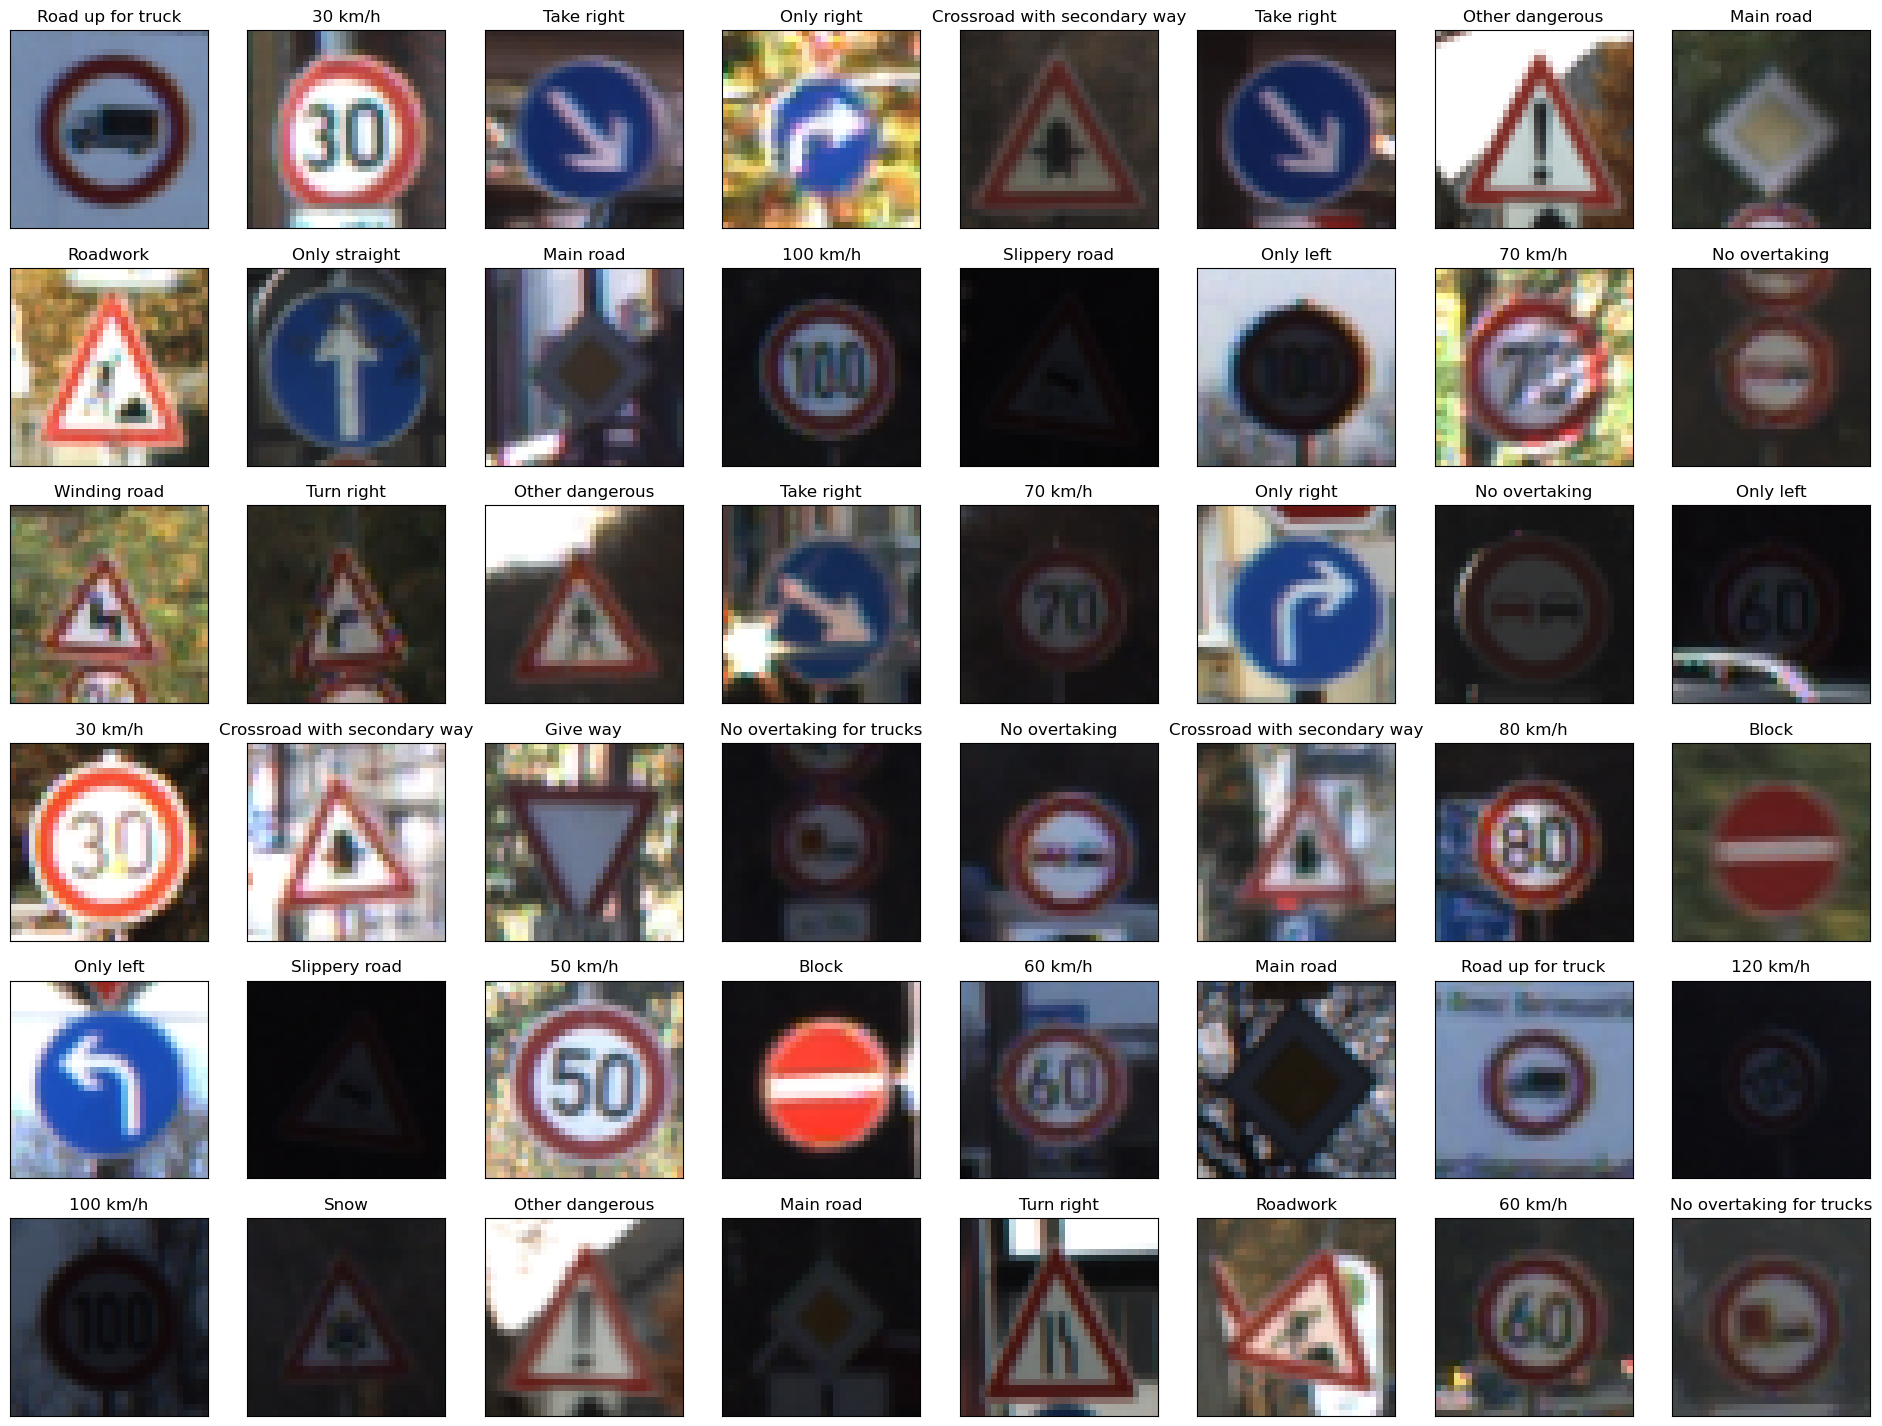

In [143]:
# Generate predictions using predict function
# Take a random test sample
test_data_iterator = iter(testloader)
data, labels = next(test_data_iterator)

predicted_labels = model(data).argmax(1) # might need to set to model.eval()!!!

input_im = data[0:48] # 6 rows
ground_truth = labels[0:48]
predicted = predicted_labels[0:48].numpy()

visualise_data(input_im, categories = predicted, class_names=class_labels, images_per_row=8)


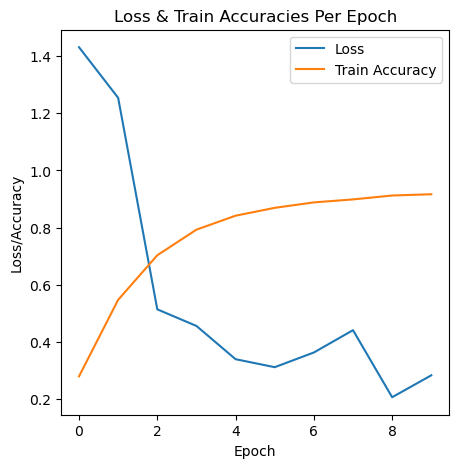

In [146]:
# Read logs
epochs=range(len(loss_log))
plt.figure(figsize=(5,5))
plt.plot(epochs,loss_log,label="Loss")
plt.plot(epochs,accuracy_log, label="Train Accuracy")
plt.title("Loss & Train Accuracies Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()

### Data Augmentation
We haven't looked at data augmentation yet. Here we'll apply some transforms to our training data.

In [147]:
# Data augmentations - make sure to transform to tensor!
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomHorizontalFlip(p=0.05),
                                      transforms.RandomVerticalFlip(p=0.05),
                                      transforms.RandomRotation(degrees=10)
                                      ])

test_transform = transforms.Compose([transforms.ToTensor()]) # we don't apply transforms to our test images

# Create an instance of the German Roadsign dataset for the training and test set (no validation set provided, however we could partition one)
# Remember we defined TrafficSignData(train=True, transform=None)
train_set_aug = TrafficSignData(train=True, transform=train_transform)
test_set_aug = TrafficSignData(train=False, transform=test_transform)

# Now we need to pass the dataset to the Pytorch dataloader class along with some other arguments
# DataLoader(dataset = dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=N_WORKERS), make sure to shuffle the train dataset!
trainloader_aug = DataLoader(dataset = train_set_aug, shuffle=True, batch_size=BATCH_SIZE, num_workers=N_WORKERS)
testloader_aug = DataLoader(dataset = test_set_aug, shuffle=False, batch_size=BATCH_SIZE, num_workers=N_WORKERS)

### Train your previous model with the augmented data

In [148]:
model_aug = CNNClassifier()

optimizer_aug = torch.optim.Adam(model_aug.parameters(), lr=LEARNING_RATE)

In [149]:
# simple empty array to log the loss
loss_log_aug = []
accuracy_log_aug = []

# Perform 10 epochs
for epoch in range(10):
    correct = 0
    loop = tqdm(trainloader_aug)
    for idx, (x_batch, y_batch) in enumerate(loop):
        # perform forward pass
        target_pred = model_aug(x_batch)

        # calc loss
        loss = loss_function(target_pred, y_batch)

        # calc accuracy
        correct += torch.sum(target_pred.argmax(1) == y_batch)

        # zero gradients from previous step to avoid adding gradients
        optimizer_aug.zero_grad()

        # calculate new gradients
        loss.backward()

        # perform gradient descent
        optimizer_aug.step()

    # Store loss at end of epoch
    loss_log_aug.append(loss.item())

    # Store accuracy at end of epoch
    train_acc = correct/len(train_set_aug)
    accuracy_log_aug.append(train_acc)

    # Print out results
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}, Train Accuracy: {train_acc}")

    

100%|██████████| 307/307 [00:39<00:00,  7.69it/s]


Epoch: 1, Loss: 2.1373114585876465, Train Accuracy: 0.20541201531887054


100%|██████████| 307/307 [00:36<00:00,  8.40it/s]


Epoch: 2, Loss: 1.3334407806396484, Train Accuracy: 0.4544364809989929


100%|██████████| 307/307 [00:34<00:00,  8.87it/s]


Epoch: 3, Loss: 1.0791488885879517, Train Accuracy: 0.5789487361907959


100%|██████████| 307/307 [00:37<00:00,  8.14it/s]


Epoch: 4, Loss: 0.6071100234985352, Train Accuracy: 0.6705093383789062


100%|██████████| 307/307 [00:36<00:00,  8.46it/s]


Epoch: 5, Loss: 0.989307701587677, Train Accuracy: 0.7283532023429871


100%|██████████| 307/307 [00:41<00:00,  7.40it/s]


Epoch: 6, Loss: 0.5488162040710449, Train Accuracy: 0.7651814818382263


100%|██████████| 307/307 [00:32<00:00,  9.33it/s]


Epoch: 7, Loss: 0.5511112213134766, Train Accuracy: 0.7982606291770935


100%|██████████| 307/307 [00:31<00:00,  9.60it/s]


Epoch: 8, Loss: 0.3855851888656616, Train Accuracy: 0.8090744614601135


100%|██████████| 307/307 [00:32<00:00,  9.38it/s]


Epoch: 9, Loss: 0.5112257599830627, Train Accuracy: 0.8260603547096252


100%|██████████| 307/307 [00:32<00:00,  9.50it/s]

Epoch: 10, Loss: 0.6427883505821228, Train Accuracy: 0.8379198908805847


In [150]:
PATH = "../Tutorial_2/checkpoints/checkpoint2_data_aug.pth"
torch.save({
            'epoch': epoch,
            'model_state_dict': model_aug.state_dict(),
            'optimizer_state_dict': optimizer_aug.state_dict(),
            'loss': loss_log_aug, # here we will save the entire loss history
            'accuracy': accuracy_log_aug,
            }, PATH)

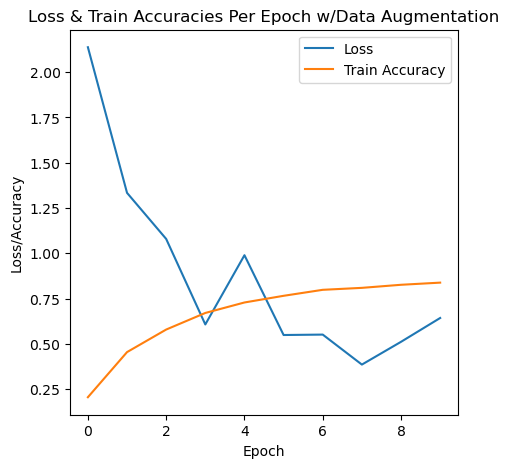

In [151]:
# Read logs
epochs=range(len(loss_log_aug))
plt.figure(figsize=(5,5))
plt.plot(epochs,loss_log_aug,label="Loss")
plt.plot(epochs,accuracy_log_aug, label="Train Accuracy")
plt.title("Loss & Train Accuracies Per Epoch w/Data Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()

Did augmenting your data imporve your model's performance? This can mean in terms of accuracy/loss as well as other metrics such as training time. 

Why or why not?

## Part 2: PyTorch Lightning Integration

Alright, we've gone through the basics of PyTorch. Now we are going to utilise PyTorch Lightning to produce more readable code by abstracting some of the nitty gritty away.

Using the same model architecture as you used in Part 1, we will rewrite the class using LightningModule instead of nn.Module.

### Rewritng the Class

In [158]:
class CNNClassifierLightning(LightningModule): # This is our main model
    def __init__(self, learning_rate=1e-4,train_loader=trainloader, test_loader=testloader):
        super().__init__()

        self.learning_rate = learning_rate
        self.train_loader = trainloader
        self.test_loader = testloader

        self.loss_func = nn.CrossEntropyLoss() # loss func
        self.act1 = nn.ReLU() # activation func

        self.train_accuracy = Accuracy(task="multiclass", num_classes=43) # Accuracy object to calculate accuracy
        self.test_accuracy = Accuracy(task="multiclass", num_classes=43)

        # BSxWxHxC: Input is BSx32x32x3, output is BSx32x32x16
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2, stride=1)

        # Input is BSx16x16x16, output is BSx16x16x32
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2, stride=1)

        # Input is BSx8x8x32, output is BSx8x8x64
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2, stride=1)

        # Input is BSx4x4x64
        self.fc1 = nn.Linear(4*4*64, 128)

        self.out = nn.Linear(128,43)

        # Define Max Pooling (Default stride = kernel size)
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        # conv 1
        x = F.dropout(self.maxpool(self.act1(self.conv1(x))), p=0.2)

        # conv 2
        x = F.dropout(self.maxpool(self.act1(self.conv2(x))), p=0.2)

        # conv 3
        x = F.dropout(self.maxpool(self.act1(self.conv3(x))), p=0.2)

        # flatten for linear layers
        x = x.view(x.shape[0],-1)

        # fc1
        x = F.dropout((self.act1(self.fc1(x))), p=0.5)

        # output
        out = self.out(x)
        # don't need softmax here since we'll use cross-entropy as our loss function
        return out
    
    #################################
    # MODEL TRAINING/EVALUATION HOOKS
    #################################

    def training_step(self, batch, batch_idx):
        x,y = batch
        logits = self(x)
        loss = self.loss_func(logits,y)

        preds = logits.argmax(1) # get output with highest probability -> predicted class
        self.train_accuracy.update(preds,y)

        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    # def validation_step(self, batch, batch_idx):
    #     x,y = batch
    #     logits = self(x)
    #     loss = self.loss_func(logits,y)

    #     preds = logits.argmax(1) # get output with highest probability -> predicted class
    #     self.val_accuracy.update(preds,y)

    #     # Calling self.log will surface up scalars for you in TensorBoard
    #     self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
    #     self.log("val_acc", self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x,y = batch
        logits = self(x)
        loss = self.loss_func(logits,y)

        preds = logits.argmax(1) # get output with highest probability -> predicted class
        self.test_accuracy.update(preds,y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        softmax = nn.Softmax() # For model evaluation, we either pass our output through a softmax layer or perform an argmax() call
        return softmax(self(batch)) # return softmax probabilities 

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate) # we'll use Adam
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return trainloader

    # def val_dataloader(self):
    #     return valloader

    def test_dataloader(self):
        return testloader

### Rewritng the Training Loop

In [160]:
# Initialize Model
model_task2 = CNNClassifierLightning(learning_rate=1e-4,train_loader=trainloader, test_loader=testloader) # use unaugmented for this task

# Define checkpoint callback function to save best model
checkpoint_callback = ModelCheckpoint(monitor="train_acc",
                                     dirpath="checkpoints",
                                     filename='task2_ckpt1',
                                     save_top_k=1,
                                     mode="max",
                                     every_n_epochs=1) # save model parameters that give best train acc

# Train model for 10 epochs
trainer_task2 = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    max_epochs=10,
    callbacks=[TQDMProgressBar(refresh_rate=20), checkpoint_callback],
    logger=CSVLogger(save_dir="logs_task2/"),
)
trainer_task2.fit(model_task2, trainloader)

# Evaluate Model
trainer_task2.test(dataloaders=testloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/nyankyaw/anaconda3/envs/MDN_main/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /home/nyankyaw/DummyProject/Tutorial_2/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params
------------------------------------------------------
0 | loss_func      | CrossEntropyLoss   | 0     
1 | act1           | ReLU               | 0     
2 | train_accuracy | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
4 | conv1          | Conv2d             | 1.2 K 
5 | conv2          | Conv2d             | 12.8 K
6 | conv3          | Conv2d             | 51.3 K
7 | fc1            | Linear             | 131 K 
8

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /home/nyankyaw/DummyProject/Tutorial_2/checkpoints/task2_ckpt1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/nyankyaw/DummyProject/Tutorial_2/checkpoints/task2_ckpt1.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7372129559516907
        test_loss           0.9495331645011902
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.9495331645011902, 'test_acc': 0.7372129559516907}]

### Visualise Results

In [167]:
# read logs for model
train_log_t2 = pd.read_csv(trainer_task2.logger.log_dir + "/metrics.csv")
train_log_t2.set_index("epoch", inplace=True)
train_log_t2 = train_log_t2.groupby(level=0).sum().drop("step",axis=1)

In [ ]:
epochs = range(10)
plt.figure(figsize=(15,12))
plt.plot(epochs, train_log_t2["train_acc"], label="Train Accuracy")
plt.plot(epochs, train_log_t2["train_loss"], label="Train Loss")
plt.title("Train Loss/Accuracy for Task 2")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()

: 

## Part 3: Improving Your Resutls

[Optional section] If you have some time and want to explore a bit more, see if you can improve your results.